In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from pymc import math as pm_math

# Simulate Data as

$$ Y_i = \alpha + \beta X + \sqrt{1-\delta^2}V_{0} + \delta V_1 - U $$

In [2]:
np.random.seed(42)

In [3]:
# Simulate data
n = 100
X = np.random.normal(1, 1, size=(n,1)) # One regressor
X_design = np.hstack([np.ones((n, 1)), X]) # Add intercept
alpha_true = 5
beta_true = 2
sigma_u_true = 1.0
sigma_v_true = 1.5
lambda_true = -0.5

In [4]:
# Compute delta
delta_true = lambda_true / np.sqrt(1 + lambda_true ** 2)

In [5]:
# Simulate inefficiency and noise components
U = np.abs(np.random.normal(0, sigma_u_true, size=n))
V0 = np.random.normal(0, sigma_v_true, size=n)
V1 = np.abs(np.random.normal(0, sigma_v_true, size=n))

In [6]:
# Compute composite error
V = np.sqrt(1 - delta_true ** 2) * V0 + delta_true * V1
Y = alpha_true + beta_true * X[:, 0] + V - U

In [7]:
# Create DataFrame
sim_data = pd.DataFrame({"Y": Y, "X": X[:, 0]})

In [8]:
sim_data

,Y,X
0,6.501973,1.496714
1,6.679417,0.861736
2,8.904428,1.647689
3,10.248157,2.523030
4,4.508049,0.765847
...,...,...
95,2.443284,-0.463515
96,6.766117,1.296120
97,6.872466,1.261055
98,7.965752,1.005113


# Model Specification

Priors

$$ \alpha \sim N(\mu_\alpha, \sigma_\alpha^2) $$
$$ \beta \sim N(\mu_\beta, \sigma_\beta^2) $$
$$ \sigma_v^2 \sim IG(\alpha_v, \beta_v) $$
$$ \sigma_u^2 \sim IG(\alpha_u, \beta_u) $$
$$ \lambda \sim TN(\mu_\lambda, \sigma_\lambda^2; a, b)$$

In [9]:
model = pm.Model()
with model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma_v = pm.InverseGamma('sigma_v', alpha=2.33, beta=3)
    sigma_u = pm.InverseGamma('sigma_u', alpha=4, beta=4)
    lam = pm.TruncatedNormal('lambda', mu=-2, sigma=10, lower=-10, upper=0)

    # Derived parameter
    delta = pm.Deterministic("delta", lam / pm.math.sqrt(1 + lam**2))

    # Latent variables
    V0 = pm.Normal("V0", mu=0, sigma=sigma_v, shape=n)
    V1 = pm.HalfNormal("V1", sigma=sigma_v, shape=n)
    U = pm.HalfNormal("U", sigma=sigma_u, shape=n)

    # Composite error
    epsilon = pm.Deterministic("epsilon", pm.math.sqrt(1 - delta**2) * V0 + delta * V1 - U)

    # Linear model
    mu = pm_math.flatten(alpha + beta * X)

    # Observed outcome
    y_obs = pm.Normal('y_obs', mu=mu + epsilon, sigma=1e-6, observed=Y)

    # Technical Efficiency
    TE = pm.Deterministic("TE", pm.math.exp(-U))

    # Sampling
    trace = pm.sample(1000, tune=500, target_accept=0.99, chains=100, random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (100 chains in 4 jobs)
NUTS: [alpha, beta, sigma_v, sigma_u, lambda, V0, V1, U]


Output()

Sampling 13 chains for 500 tune and 941 draw iterations (6_500 + 12_233 draws total) took 156 seconds.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 5 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 7 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 8 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 9 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 10 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 11 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 12 reache

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnin

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,9.815,1.544,7.871,11.508,0.154,0.348,101.0,101.0,42.66
beta,-0.277,0.364,-0.798,0.257,0.036,0.071,101.0,101.0,41.38
sigma_u,1.470,0.745,0.496,2.814,0.074,0.042,101.0,101.0,23.82
sigma_v,2.490,1.460,0.830,5.407,0.145,0.092,101.0,101.0,24.74
lambda,-2.741,2.027,-6.535,-0.183,0.202,0.116,101.0,101.0,39.69
delta,-0.828,0.182,-0.991,-0.471,0.018,0.018,101.0,101.0,39.69


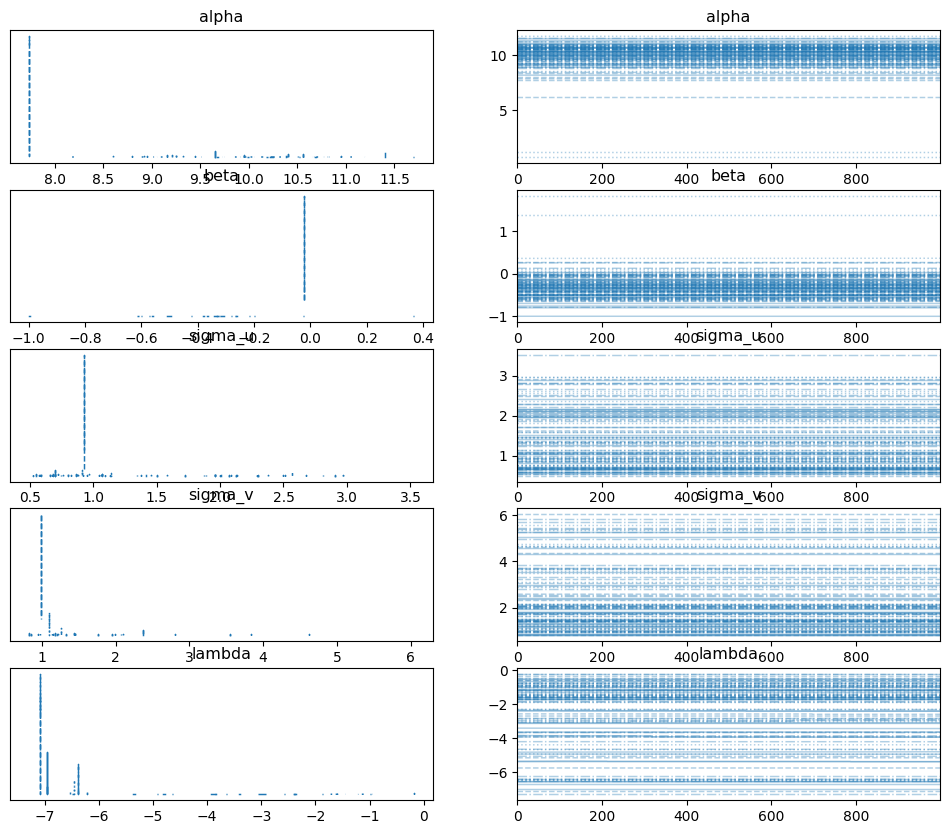

In [33]:
az.plot_trace(trace, var_names=["alpha", "beta", "sigma_u", "sigma_v", "lambda"])
az.summary(trace, var_names=["alpha", "beta", "sigma_u", "sigma_v", "lambda", "delta"])


In [31]:
import numpy as np
import pandas as pd
from scipy.stats import halfnorm, skewnorm

np.random.seed(123)

# Parameters
n = 50
alpha = 5
beta = 2
sigma_u = 1
sigma_v = 1.5
lambda_skew = -0.5

# Simulate input X
X = np.random.normal(1, 1, n)

# Inefficiency term U ~ HalfNormal(0, sigma_u)
U = halfnorm(scale=sigma_u).rvs(n)

# Location ξ = α + βX − U
xi = alpha + beta * X - U

# Simulate Y ~ SkewNormal(ξ, sigma_v, lambda_skew)
Y = skewnorm(a=lambda_skew, loc=xi, scale=sigma_v).rvs(n)

# Put in DataFrame for convenience
data = pd.DataFrame({'X': X, 'Y': Y})


In [32]:
import pymc as pm
import arviz as az

with pm.Model() as model:
    # Priors for parameters
    alpha_ = pm.Normal('alpha', mu=5, sigma=5)
    beta_ = pm.Normal('beta', mu=2, sigma=2)
    sigma_u = pm.HalfNormal('sigma_u', sigma=1.2)
    sigma_v = pm.HalfNormal('sigma_v', sigma=1.5)
    lam = pm.Normal('lam', mu=-5, sigma=5)

    # Latent inefficiency U ~ HalfNormal(0, sigma_u)
    U = pm.HalfNormal('U', sigma=sigma_u, shape=n)

    # Linear predictor with inefficiency
    mu = alpha_ + beta_ * data['X'] - U

    # Skew-Normal likelihood
    Y_obs = pm.SkewNormal('Y_obs', mu=mu, sigma=sigma_v, alpha=lam, observed=data['Y'])

    # MCMC Sampling
    trace = pm.sample(2000, tune=1000, target_accept=0.99, return_inferencedata=True)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_u, sigma_v, lam, U]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,3.24,0.97,1.58,5.22,0.03,0.02,798.11,1354.79,1.00
beta,2.33,0.18,2.00,2.67,0.00,0.00,3979.57,5148.59,1.00
lam,1.58,2.30,-1.86,6.12,0.12,0.07,374.30,1295.70,1.00
sigma_u,1.01,0.57,0.04,1.91,0.04,0.01,178.89,325.19,1.01
sigma_v,1.76,0.33,1.14,2.37,0.01,0.00,1999.68,3386.30,1.00
U[0],0.60,0.57,0.00,1.67,0.02,0.01,462.94,1841.74,1.01
U[1],1.12,0.95,0.00,2.83,0.05,0.01,273.08,973.73,1.01
U[2],1.55,1.24,0.00,3.62,0.08,0.02,225.66,948.83,1.00
U[3],1.68,1.36,0.00,3.98,0.09,0.02,212.65,768.39,1.01
U[4],0.40,0.41,0.00,1.16,0.01,0.01,749.91,2425.69,1.00


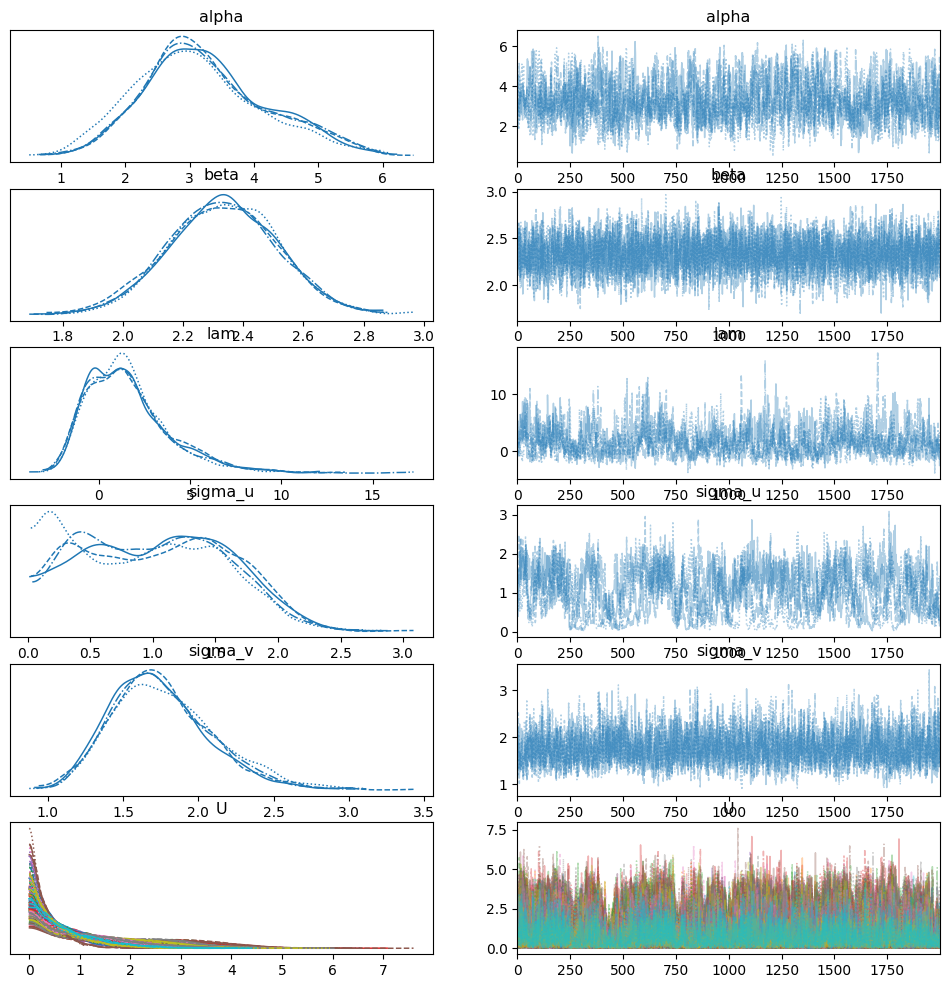

In [33]:
az.plot_trace(trace)
az.summary(trace, round_to=2)


In [14]:
with pm.Model() as model:
    # Priors on regression parameters
    alpha_ = pm.Normal('alpha', mu=0, sigma=10)
    beta_ = pm.Normal('beta', mu=0, sigma=10)

    # Inverse-Gamma priors on VARIANCES
    sigma2_u = pm.InverseGamma('sigma2_u', alpha=0.01, beta=0.01)
    sigma2_v = pm.InverseGamma('sigma2_v', alpha=0.01, beta=0.01)

    # Convert to std dev for use in HalfNormal and SkewNormal
    sigma_u = pm.Deterministic('sigma_u', pm.math.sqrt(sigma2_u))
    sigma_v = pm.Deterministic('sigma_v', pm.math.sqrt(sigma2_v))

    # Latent inefficiency
    U = pm.HalfNormal('U', sigma=sigma_u, shape=n)

    # Linear predictor
    mu = alpha_ + beta_ * data['X'] - U

    # Skew-normal likelihood
    lam = pm.Normal('lam', mu=0, sigma=10)
    Y_obs = pm.SkewNormal('Y_obs', mu=mu, sigma=sigma_v, alpha=lam, observed=data['Y'])

    trace = pm.sample(2000, tune=1000, target_accept=0.99, return_inferencedata=True)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma2_u, sigma2_v, U, lam]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 40 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,4.74,0.71,3.51,5.81,0.04,0.01,372.19,1818.17,1.02
beta,1.99,0.10,1.81,2.17,0.00,0.00,1596.77,4499.67,1.00
lam,-0.82,6.99,-13.82,15.27,0.77,0.39,79.26,515.60,1.04
sigma2_u,1.62,1.21,0.00,3.57,0.27,0.07,20.84,128.39,1.13
sigma2_v,1.81,1.04,0.26,3.68,0.20,0.03,26.70,249.07,1.11
...,...,...,...,...,...,...,...,...,...
U[97],0.45,0.39,0.00,1.13,0.02,0.01,289.71,3116.77,1.02
U[98],0.52,0.42,0.00,1.26,0.03,0.00,125.77,1733.27,1.03
U[99],0.66,0.51,0.00,1.56,0.06,0.01,70.63,1000.45,1.04
sigma_u,1.14,0.56,0.09,1.90,0.13,0.03,20.84,128.39,1.13


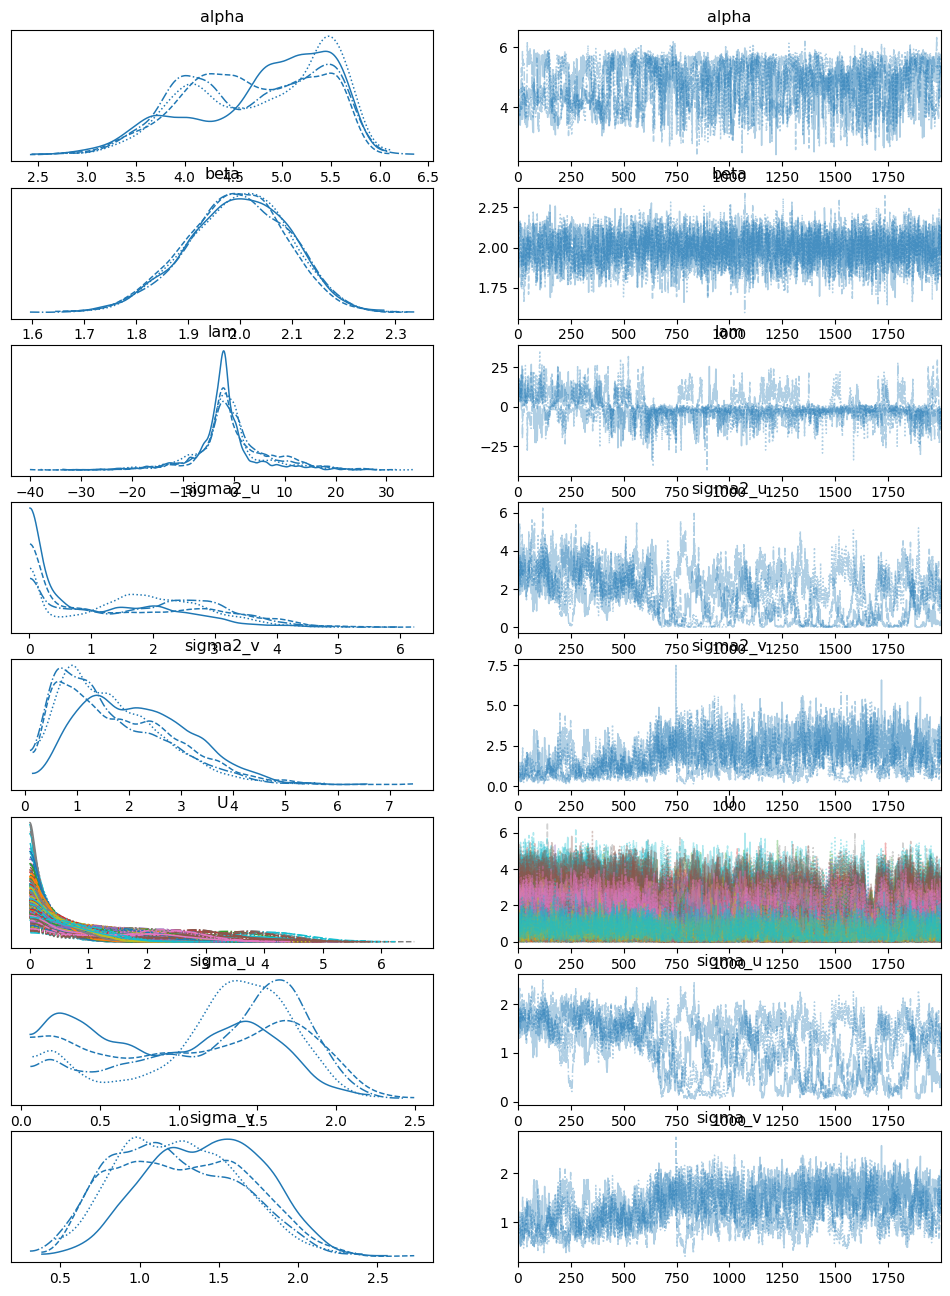

In [15]:
az.plot_trace(trace)
az.summary(trace, round_to=2)

In [16]:
import numpy as np
import arviz as az

# Extract posterior samples of inefficiency U
posterior = trace.posterior
U_samples = posterior['U'].stack(samples=("chain", "draw")).values  # shape: (n, total_samples)

# Compute TE = exp(-U) for each draw
TE_samples = np.exp(-U_samples)  # same shape: (n, total_samples)

# Optional: summarize posterior mean TE
TE_mean = TE_samples.mean(axis=1)  # shape: (n,)


In [17]:
import pandas as pd

# Combine with original data
TE_df = pd.DataFrame({
    'X': data['X'],
    'Y': data['Y'],
    'TE_mean': TE_mean
})

# View technical efficiency estimates
print(TE_df.head())


          X         Y   TE_mean
0 -0.085631  3.756309  0.587308
1  1.997345  6.770463  0.425858
2  1.282978  3.458969  0.292755
3 -0.506295  0.875614  0.350042
4  0.421400  5.906319  0.745949


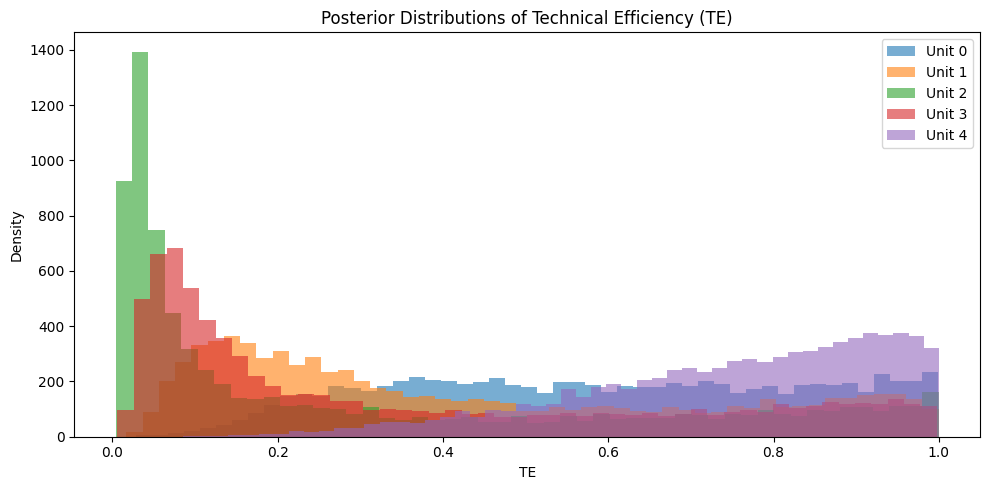

In [18]:
import matplotlib.pyplot as plt

# Plot posterior distribution of TE for a few units
plt.figure(figsize=(10, 5))
for i in range(5):  # plot first 5 units
    plt.hist(TE_samples[i], bins=50, alpha=0.6, label=f'Unit {i}')
plt.title("Posterior Distributions of Technical Efficiency (TE)")
plt.xlabel("TE")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()
